In [40]:
import numpy as np
import scipy.io
import os
import glob
import sys
import matplotlib.pyplot as plt

data_files = glob.glob(os.path.join("./Data", '*.mat'))
print(data_files)

['./Data/S01.mat', './Data/S05.mat', './Data/S02.mat', './Data/S10.mat', './Data/S08.mat', './Data/S07.mat', './Data/S06.mat', './Data/S03.mat', './Data/S09.mat', './Data/S04.mat']


In [44]:
def CSCEA490_HW_ERP(pNum):
    """
    This function loads one or more preprocessed ERP datasets, computes the category-level averaged ERPs,
    and generates the following plots: 
    - Per-category temporally resolved voltage topomaps.
    - Per-category ERPs for selected electrodes.
    - Within-category single-image ERPs for Human Face and Inanimate Object categories.

    Parameters:
    pNum (int or list): The participant number to be analyzed. Enter numbers between 1 and 10 to plot data from a specific participant, or 0 to plot data from all participants.

    Returns:
    None: The function saves a number of figures in the Figure directory.
    """
    global t, XCatMean, rgb10, cStr, labels72, labels6,subID,fs,blCorrectIdx
    "-------------------"
    print("\033[H\033[J")
    print("- * - * - * - * Beginning function call * - * - * - * -\n")
    # Make sure a number was entered
    if not isinstance(pNum, int):
        raise ValueError('The function requires one input (the participant number)')
    # Add to path all files and folders in the parent directory of "Code"
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    sys.path.append(parent_dir)
    # Time windows and labels -- not using right now
    tWinIdx = np.tile(np.arange(1, 7), (11, 1)) + np.tile(np.arange(-6, 25, 3).reshape(-1, 1), (1, 6)) + 7
    tWinLabel = ['-96 to -16 msec', '-48 to 32 msec', '0 to 80 msec', 
                 '48 to 128 msec', '96 to 176 msec', '144 to 224 msec', 
                 '192 to 272 msec', '240 to 320 msec', '288 to 368 msec', 
                 '336 to 416 msec', '384 to 464 msec']
    # # Colour palette
    # colors = scipy.io.loadmat('colors.mat')
    # rgb10 = colors['rgb10']
    # rgb10 = np.delete(rgb10, [5, 6, 7], axis=0) #Force used colors to align with category numbering
    # Category labels
    cStr = ['HB', 'HF', 'AB', 'AF', 'FV', 'IO']
    "-------------------"
    # Analysis 0: Load the data and print some information about it.
    plt.close('all')
    X = np.empty((0, 0, 0))
    labels6 = np.array([])
    labels72 = np.array([])
    # If 0 was entered, update pNum to include all 10 files
    if pNum == 0:
        print('Using all 10 files!')
        pNum = range(1, 11)
    elif isinstance(pNum, int):
        pNum = [pNum]
    # Iterate through all values of pNum: Load each associated file and aggregate the data (X) and stim labels (labels6, labels72).
    for i in pNum:

    # Load the data and print information in console
        pStr = f'{i:02d}'
        baseFn = f'S{pStr}'
        IN = scipy.io.loadmat(f'./Data/{baseFn}.mat') 

        print(f'Participant number: {i}')
        print(f'Loaded input file {baseFn}')
        print(f"Size of data matrix (electrodes x time x trials): {IN['X'].shape}")
        print(f"Number of time samples per second (sampling rate): {IN['fs'][0][0]} Hz")
        print(f"Trial epoch: {IN['t'][0][0]} to {IN['t'][0][-1]} msec relative to stimulus onset.")
        print(IN)  # Display the struct
        # Aggregate data from multiple files and/or move out of struct fields into standalone variables.
        if X.size == 0: #EEG data
            X = IN['X']
        else:
            X = np.concatenate((X, IN['X']), axis=2)
        labels6 = np.concatenate((labels6, IN['labels6'].flatten())) # 6-class labels
        labels72 = np.concatenate((labels72, IN['labels72'].flatten())) # 72-class labels
        if 't' not in globals(): # Time axis (do only once)
            t = IN['t'].flatten()
    # Separate the trials by category and compute category means and iterate through the categories and store in 4D matrix
    num_categories = 6
    XCat = np.zeros((X.shape[0], X.shape[1], int(X.shape[2]/num_categories), num_categories))
    for i in range(1, 1+num_categories):
        XCat[:, :, :, i-1] = X[:, :, labels6 == i] #[space x time x trial x category]
    # Category-level means (averaged across the trial dimension)
    XCatMean = np.mean(XCat, axis=2) #[space x time x category]
    "-------------------"
    # Analysis 1: Plot ERPs

    # Sample data
    # These should be defined or loaded from your data source
    # t = np.linspace(-100, 800, 1000)  # Example time vector
    # XCatMean = np.random.randn(128, 1000, 6)  # Example ERP data
    # rgb10 = plt.cm.tab10.colors  # Example colors
    # cStr = ['Category1', 'Category2', 'Category3', 'Category4', 'Category5', 'Category6']  # Example category names
    # pNum = 1  # Example participant number

    # Which electrodes to use
    eUse = [11, 47, 90]
    nElectrodes = len(eUse)

    fig, axs = plt.subplots(1, nElectrodes, figsize=(12, 4), constrained_layout=True)

    yl = []

    # Iterate through the selected electrodes (one sub-plot per electrode)
    for i in range(nElectrodes):
        ax = axs[i]
        
        # Iterate through the stimulus categories (one line plot per category)
        for j in range(6):
            ax.plot(t, XCatMean[eUse[i], :, j], linewidth=1, label=cStr[j])
        
        yl.append(ax.get_ylim())  # Save the ylim so we can set all to max later
        
        ax.set_title(f'Electrode {eUse[i]}')
        ax.grid(True)
        ax.set_xlabel('Time (msec)')
        ax.set_ylabel('Voltage (μV)')
        ax.legend(loc='best')
        # ax.hold(False)

    # Iterate back through the sub-plots and standardize the ylim across plots
    absMaxYl = max(abs(np.array(yl).flatten()))
    for ax in axs:
        ax.set_ylim([-absMaxYl, absMaxYl])

    fig.suptitle(f'Participant {pNum}')

    # Save out the ERP figure
    if len(pNum) > 1:
        baseFn = 'allSubs'
    else:
        if type(pNum) == int:
            baseFn = f'S{pNum:02d}'
        elif type(pNum) == list:
            baseFn = f'S{pNum[0]:02d}'

    fnOut = f'{baseFn}_1_allCategoryERPs.png'
    fig.savefig('./Figures/' + fnOut)
    plt.show()
    plt.close(fig)

    print(f'~ * Saved allSubs_1_allCategoryERPs.png * ~')

    def plotOnEgi129_NG(data, threshold):
        # Example implementation for plotting on EGI 129 layout
        fig, ax = plt.subplots()
        # Assuming data has been reshaped to match the electrode layout
        im = ax.imshow(data.reshape(11, 12), cmap='coolwarm')  # Adjust reshape dimensions as needed
        ax.set_title('EGI 129 Layout Plot')
        plt.colorbar(im, ax=ax)
        plt.show()

    def jmaColors(palette_name):
        # Example implementation for colormap retrieval
        if palette_name == 'coolhotcortex':
            return plt.cm.coolwarm  # Replace with the actual colormap you want to use
        else:
            return plt.cm.viridis  # Default colormap

    def analysis_2_P1_N170_topoplots(XCatMean, baseFn, pNum):
        tUse = [14, np.argmin(XCatMean[95, :, 1])]
        tStr = ['P1', 'N170']
        cStr = ['Human Body', 'Human Face', 'Animal Body', 'Animal Face', 'Fruit Vegetable', 'Inanimate Object']
        fSize = 16

        for cc in range(6):
            fig, axs = plt.subplots(1, len(tUse), figsize=(10, 5), constrained_layout=True)
            aggrMin = []
            aggrMax = []

            for tt, ax in enumerate(axs):
                thisData = XCatMean[:, tUse[tt], cc]
                thisDataPlot = np.append(thisData, [np.nan]*4)  # Assuming the data is reshaped to fit EGI 129 layout
                plotOnEgi129_NG(thisDataPlot, 0.1)  # Placeholder for actual plotting
                im = ax.imshow(thisDataPlot.reshape(13, 10), cmap=jmaColors('coolhotcortex'))  # Adjust reshape accordingly

                aggrMin.append(np.min(thisData))
                aggrMax.append(np.max(thisData))
                ax.set_title(tStr[tt])
                ax.axis('off')

            absScale = max(-min(aggrMin), max(aggrMax))

            for ax in axs:
                im.set_clim(-absScale, absScale)
                ax.tick_params(labelsize=fSize)

            plt.colorbar(im, ax=axs, shrink=0.8)
            fig.suptitle(f'Category {cc+1}: {cStr[cc]}', fontsize=fSize)
            plt.show()

        fLabel = ['1_HB', '2_HF', '3_AB', '4_AF', '5_FV', '6_IO']

        for i in range(6):
            fig = plt.figure(i + 1)
            if len(pNum) > 1:
                baseFn = 'allSubs'
            else:
                if type(pNum) == int:
                    baseFn = f'S{pNum:02d}'
                elif type(pNum) == list:
                    baseFn = f'S{pNum[0]:02d}'
                    
            fnOut = f'{baseFn}_2_P1N170Topo_category_{fLabel[i]}.png'
            fig.savefig(os.path.join('.', 'Figures', fnOut))
            plt.close(fig)

        print(' ')

    # Example call assuming XCatMean, baseFn, and pNum are already defined:
    # analysis_2_P1_N170_topoplots(XCatMean, baseFn, pNum)

    # Assuming X, labels72, t, rgb10, eUse, and pNum are defined appropriately

    # Initialize empty lists for faces (XHF) and objects (XIO)
    XHF = []
    XIO = []

   # Organize exemplar-level ERPs for Human Faces (HF)
    for i in range(13, 25):  # MATLAB: for i = 13:24
        exemplar_trials = X[:, :, np.where(labels72 == i)[0]]
        XHF.append(exemplar_trials)  # space x time x trials x exemplar

    XHF_array = np.array(XHF)
    XHF_mean = np.mean(XHF_array, axis=3)  # mean over exemplars

    # Organize exemplar-level ERPs for Inanimate Objects (IO)
    for i in range(61, 73):  # MATLAB: for i = 61:72
        exemplar_trials = X[:, :, np.where(labels72 == i)[0]]
        XIO.append(exemplar_trials)  # space x time x trials x exemplar

    XIO_array = np.array(XIO)
    XIO_mean = np.mean(XIO_array, axis=3)  # mean over exemplars

    # Use the first electrode for plotting
    eUse = 96  # or specify the index of the electrode you want to plot

    # Plot the ERPs
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Plot for Human Faces
    axs[0].plot(t, np.squeeze(XHF_mean[:, eUse, :]).T)
    axs[0].set(xlabel='Time (msec)', ylabel='Voltage (\u03BCV)',
            title=f'Human Faces, electrode {eUse+1}')
    axs[0].grid(True)

    # Plot for Inanimate Objects
    axs[1].plot(t, np.squeeze(XIO_mean[:, eUse, :]).T)
    axs[1].set(xlabel='Time (msec)', ylabel='Voltage (\u03BCV)',
            title=f'Inanimate Objects, electrode {eUse+1}')
    axs[1].grid(True)

    # Standardize y-limits across subplots
    yl = [ax.get_ylim() for ax in axs]
    absY = np.max(np.abs(yl))
    for ax in axs:
        ax.set_ylim([-absY, absY])

    # Save the figure
    ww = 12
    hh = ww / 3
    fig.set_size_inches(ww, hh)
    if len(pNum) > 1:
        baseFn = 'allSubs'
    else:
        if type(pNum) == int:
            baseFn = f'S{pNum:02d}'
        elif type(pNum) == list:
            baseFn = f'S{pNum[0]:02d}'
    fnOut = f'{baseFn}_3_withinCategoryExemplarERPs.png'
    plt.savefig('./Figures/' + fnOut)
    plt.show()  # Display the figure
    plt.close()

    print('\n- * - * - * - * Function call complete * - * - * - * -')


- * - * - * - * Beginning function call * - * - * - * -

Using all 10 files!
Participant number: 1
Loaded input file S01
Size of data matrix (electrodes x time x trials): (124, 40, 5184)
Number of time samples per second (sampling rate): 62.5 Hz
Trial epoch: -112 to 512 msec relative to stimulus onset.
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 23 12:03:37 2024', '__version__': '1.0', '__globals__': [], 'X': array([[[ 6.81707249e-01,  6.12331492e+00, -3.50180003e-01, ...,
         -1.29607533e+00,  3.50677828e+00,  3.26119584e+00],
        [-4.00852703e-01,  5.87402826e+00,  3.76884529e+00, ...,
          1.56447845e+00,  9.60153969e-01, -1.47196387e-01],
        [-2.71508145e+00,  1.25093677e+00,  8.33227639e+00, ...,
         -2.91881059e+00, -1.63589570e-01,  6.35582900e-01],
        ...,
        [-5.94824349e+00,  9.32218265e+00, -3.99369011e+00, ...,
          8.77584016e+00, -2.61756030e+00, -3.69881818e+00],
        [-5.24342162e+00,  9.8350782

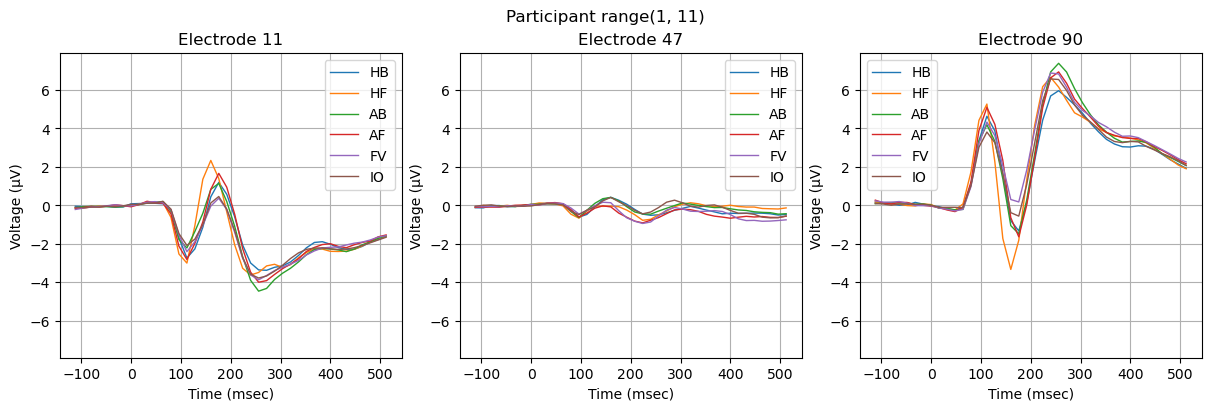

~ * Saved allSubs_1_allCategoryERPs.png * ~


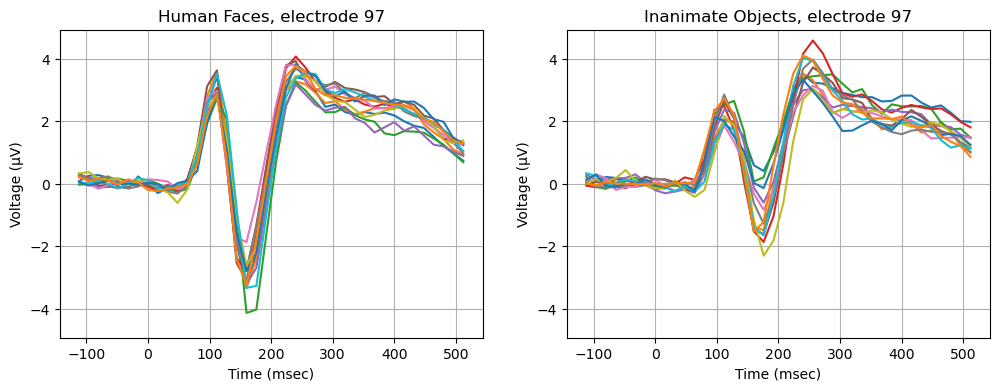


- * - * - * - * Function call complete * - * - * - * -

- * - * - * - * Beginning function call * - * - * - * -

Participant number: 1
Loaded input file S01
Size of data matrix (electrodes x time x trials): (124, 40, 5184)
Number of time samples per second (sampling rate): 62.5 Hz
Trial epoch: -112 to 512 msec relative to stimulus onset.
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 23 12:03:37 2024', '__version__': '1.0', '__globals__': [], 'X': array([[[ 6.81707249e-01,  6.12331492e+00, -3.50180003e-01, ...,
         -1.29607533e+00,  3.50677828e+00,  3.26119584e+00],
        [-4.00852703e-01,  5.87402826e+00,  3.76884529e+00, ...,
          1.56447845e+00,  9.60153969e-01, -1.47196387e-01],
        [-2.71508145e+00,  1.25093677e+00,  8.33227639e+00, ...,
         -2.91881059e+00, -1.63589570e-01,  6.35582900e-01],
        ...,
        [-5.94824349e+00,  9.32218265e+00, -3.99369011e+00, ...,
          8.77584016e+00, -2.61756030e+00, -3.69881818e+00],


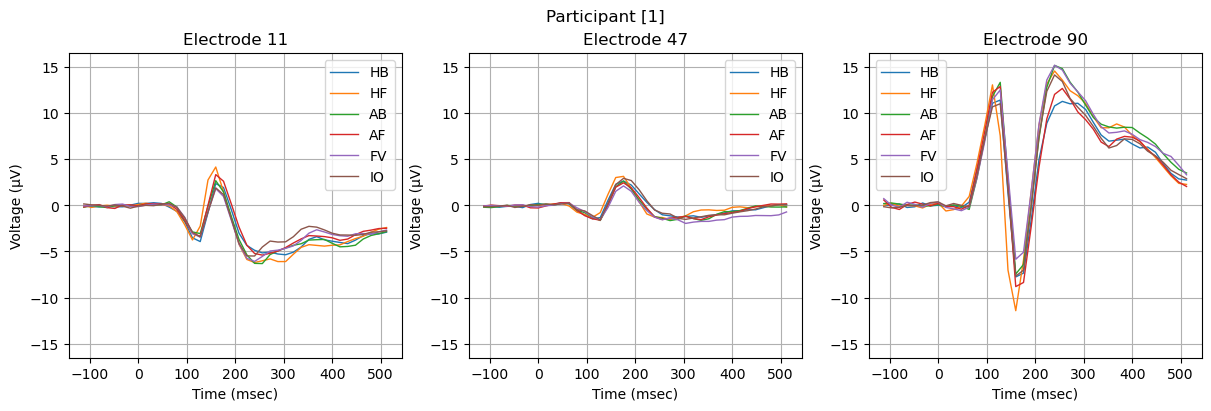

~ * Saved allSubs_1_allCategoryERPs.png * ~


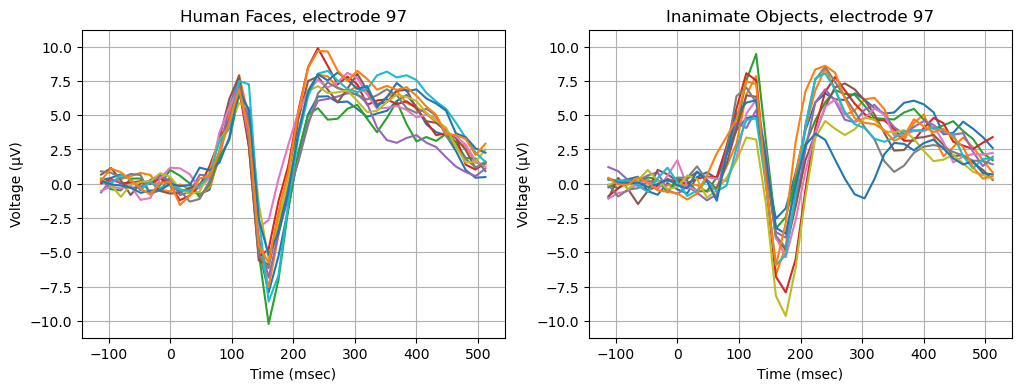


- * - * - * - * Function call complete * - * - * - * -

- * - * - * - * Beginning function call * - * - * - * -

Participant number: 2
Loaded input file S02
Size of data matrix (electrodes x time x trials): (124, 40, 5184)
Number of time samples per second (sampling rate): 62.5 Hz
Trial epoch: -112 to 512 msec relative to stimulus onset.
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 23 12:03:57 2024', '__version__': '1.0', '__globals__': [], 'X': array([[[-6.70628833e+00,  1.05746416e-01,  2.74428868e+00, ...,
         -3.21872387e-01, -1.48089681e-01,  1.04886663e+00],
        [-2.98855692e+00, -2.58848245e+00,  5.74186538e+00, ...,
          2.74044969e+00,  2.52859126e+00,  1.69559077e+00],
        [-1.93964897e+00,  3.11538465e+00,  2.21104849e+00, ...,
          1.98344417e+00,  1.81701574e+00, -5.67168003e-01],
        ...,
        [ 5.64185148e+00,  3.75167013e+00,  1.53667137e+00, ...,
         -3.40831610e+00, -1.40963123e+00, -2.15543854e+00],


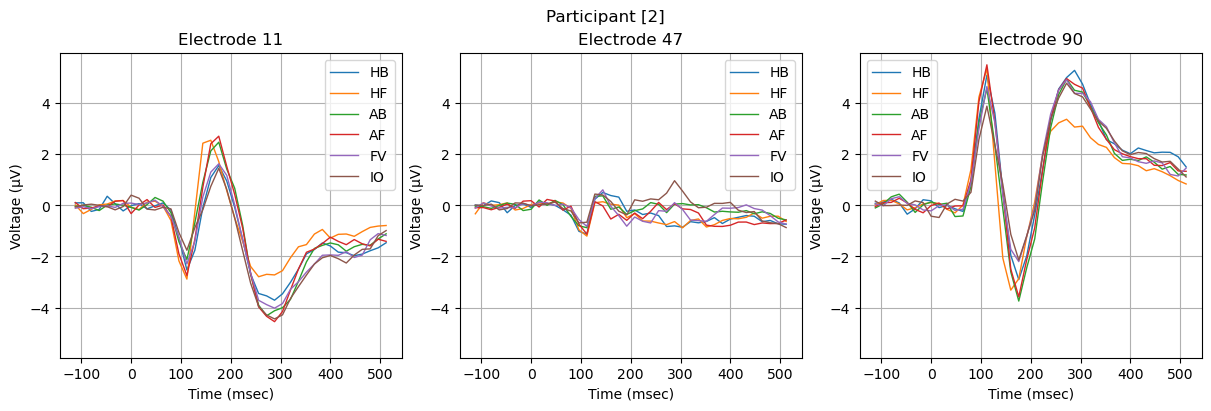

~ * Saved allSubs_1_allCategoryERPs.png * ~


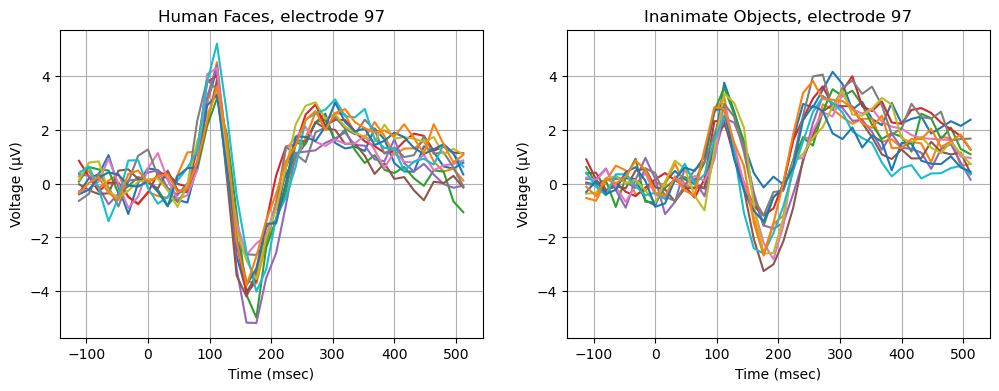


- * - * - * - * Function call complete * - * - * - * -

- * - * - * - * Beginning function call * - * - * - * -

Participant number: 3
Loaded input file S03
Size of data matrix (electrodes x time x trials): (124, 40, 5184)
Number of time samples per second (sampling rate): 62.5 Hz
Trial epoch: -112 to 512 msec relative to stimulus onset.
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 23 12:04:24 2024', '__version__': '1.0', '__globals__': [], 'X': array([[[  3.80397253,   0.44548797,   4.39627574, ...,  -1.5611063 ,
           4.26367652,   6.56157661],
        [ -4.12261569,  -3.98051244,   1.12501018, ...,  -0.6102421 ,
           3.83402544,   7.22140729],
        [ -3.50531243,   3.2158219 ,   0.31614439, ...,  -0.32180049,
           2.32322489,   5.93696798],
        ...,
        [ -7.74272829,  -1.25331483,  -8.87858167, ...,   5.66971481,
          -3.63450312,  -6.97790537],
        [ -7.00833219,   1.44609629,  -6.96249491, ...,   5.26449209,
  

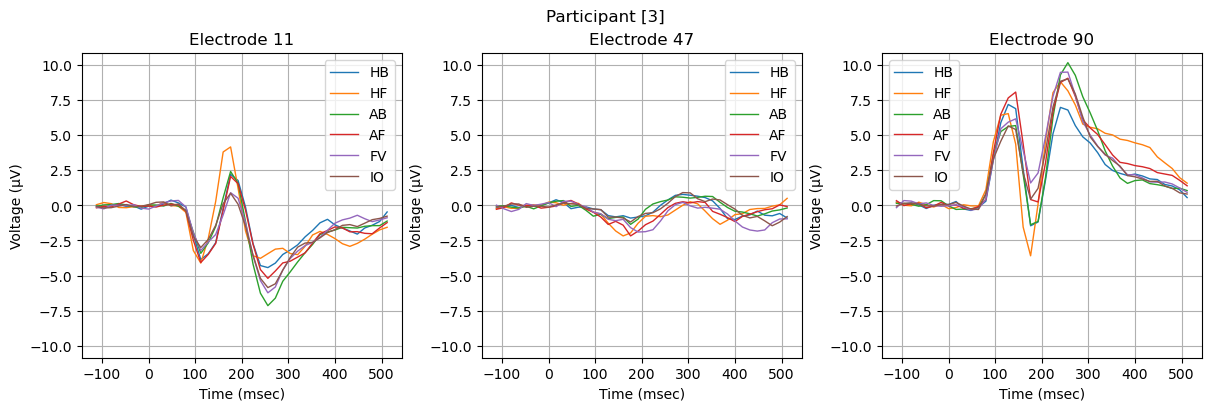

~ * Saved allSubs_1_allCategoryERPs.png * ~


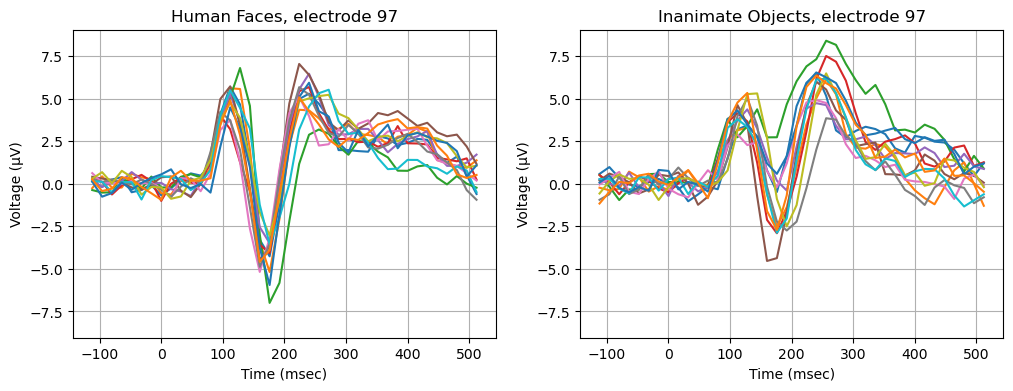


- * - * - * - * Function call complete * - * - * - * -

- * - * - * - * Beginning function call * - * - * - * -

Participant number: 4
Loaded input file S04
Size of data matrix (electrodes x time x trials): (124, 40, 5184)
Number of time samples per second (sampling rate): 62.5 Hz
Trial epoch: -112 to 512 msec relative to stimulus onset.
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 23 12:05:52 2024', '__version__': '1.0', '__globals__': [], 'X': array([[[ -1.23439064,   6.15843937,   0.42977175, ...,  -0.18962333,
          -1.92025192,   0.9462893 ],
        [ -0.2735767 ,   1.44439074,   0.12487893, ...,   2.01808155,
          -3.50319796,   0.11496877],
        [ -2.25032808,   1.21337183,  -0.76372861, ...,   0.27105147,
          -0.36225273,  -0.41072742],
        ...,
        [ -4.26092623,   1.53822969,  -5.28999401, ...,   3.60106031,
          -3.15238483,  -5.61646413],
        [ -7.78074311,   1.17361383,  -5.57633528, ...,   1.22137333,
  

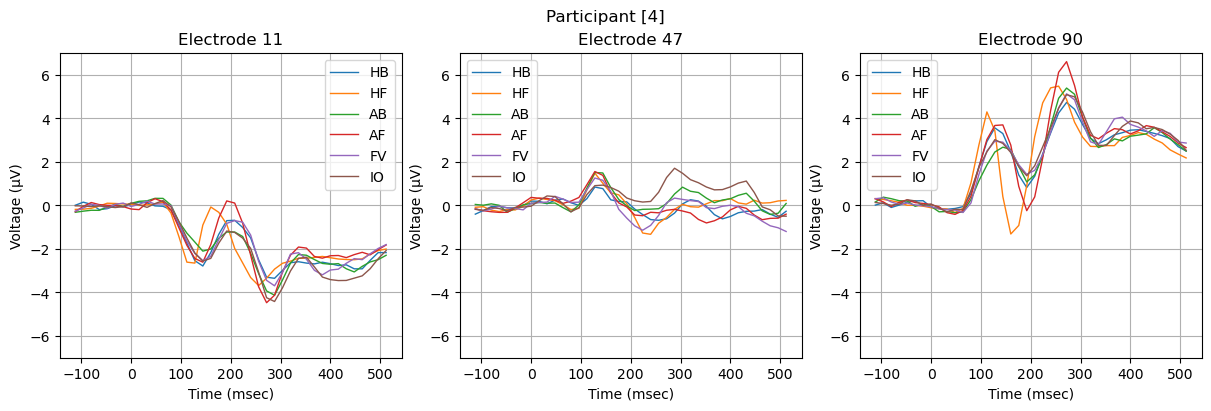

~ * Saved allSubs_1_allCategoryERPs.png * ~


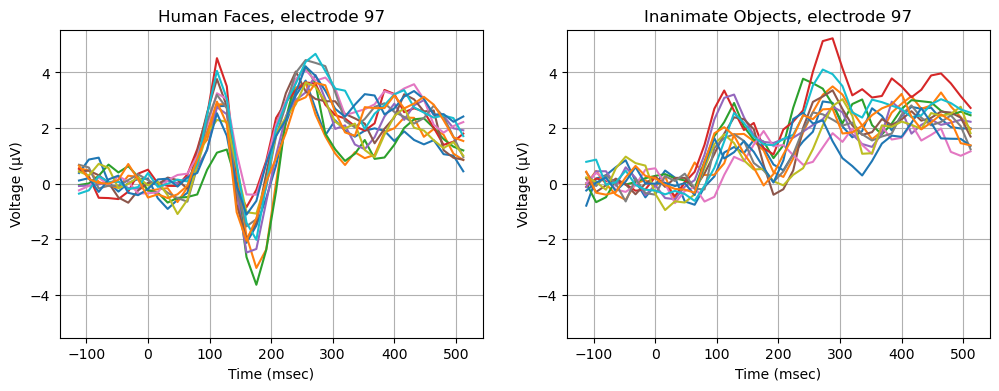


- * - * - * - * Function call complete * - * - * - * -

- * - * - * - * Beginning function call * - * - * - * -

Participant number: 5
Loaded input file S05
Size of data matrix (electrodes x time x trials): (124, 40, 5184)
Number of time samples per second (sampling rate): 62.5 Hz
Trial epoch: -112 to 512 msec relative to stimulus onset.
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 23 12:07:00 2024', '__version__': '1.0', '__globals__': [], 'X': array([[[  1.08693954,   2.95114029,  -1.4484544 , ...,   2.90782259,
          -1.28845816,  -4.15626379],
        [  2.2902189 ,   1.68411713,  -0.21132357, ...,  10.48396118,
          -1.11613593,  -8.67944272],
        [  0.87239718,  -1.61508255,   0.09320616, ...,   4.53659925,
           2.20757189,  -4.17932216],
        ...,
        [ -1.28652436,   0.32850045,  -0.35395779, ...,   1.48910882,
          -2.57350518,   4.80148418],
        [ -1.9656173 ,   1.07872797,   5.2869141 , ...,   4.58407712,
  

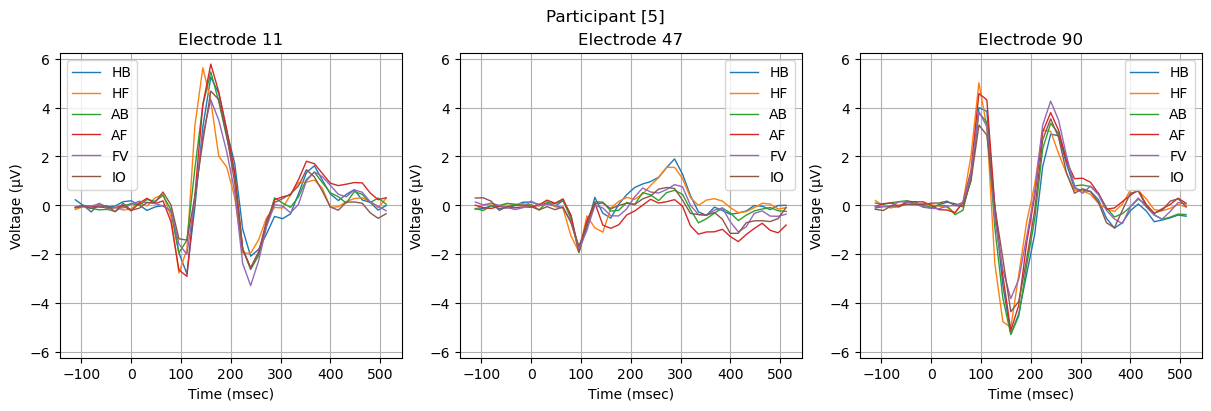

~ * Saved allSubs_1_allCategoryERPs.png * ~


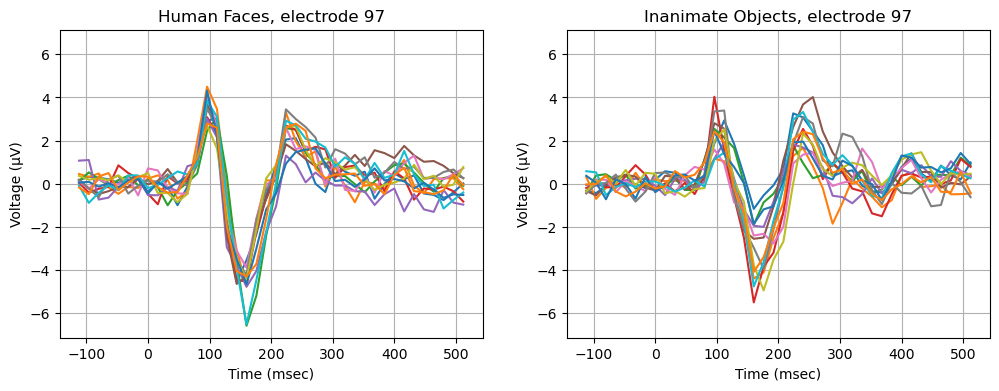


- * - * - * - * Function call complete * - * - * - * -

- * - * - * - * Beginning function call * - * - * - * -

Participant number: 6
Loaded input file S06
Size of data matrix (electrodes x time x trials): (124, 40, 5184)
Number of time samples per second (sampling rate): 62.5 Hz
Trial epoch: -112 to 512 msec relative to stimulus onset.
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 23 12:07:37 2024', '__version__': '1.0', '__globals__': [], 'X': array([[[-3.12268071e+00, -5.99900095e-01,  7.10372370e+00, ...,
         -2.12309113e+00,  3.87873524e+00,  7.52544857e-01],
        [ 9.13053986e-01, -3.25411190e+00,  3.81007411e+00, ...,
          2.12382742e+00,  5.15887643e+00, -4.69766807e-01],
        [-3.17304175e+00, -4.37543608e+00, -4.60621233e+00, ...,
         -2.14387969e+00,  5.96315170e+00,  5.46599827e-01],
        ...,
        [-3.86368225e+00,  4.45221073e-01, -2.38772072e+00, ...,
          3.00794316e+00,  6.47507170e+00, -6.32180579e+00],


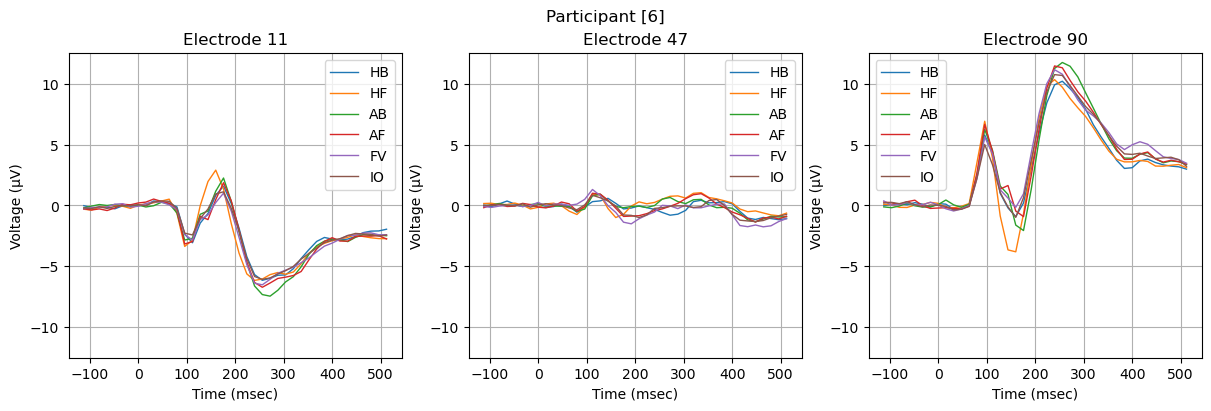

~ * Saved allSubs_1_allCategoryERPs.png * ~


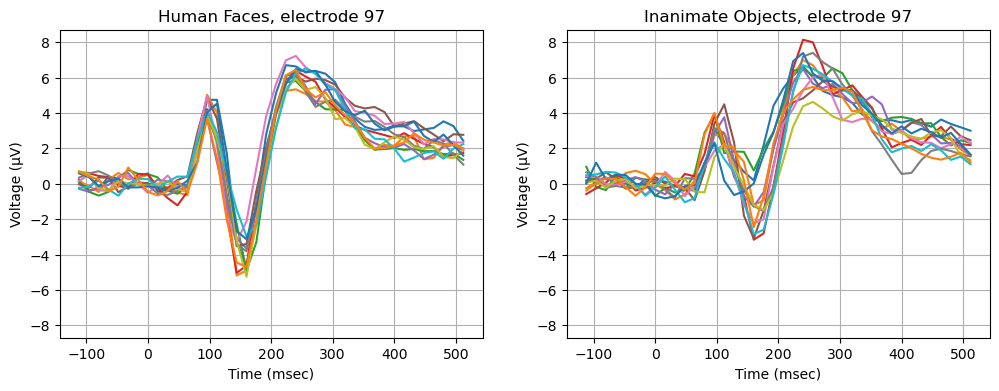


- * - * - * - * Function call complete * - * - * - * -

- * - * - * - * Beginning function call * - * - * - * -

Participant number: 7
Loaded input file S07
Size of data matrix (electrodes x time x trials): (124, 40, 5184)
Number of time samples per second (sampling rate): 62.5 Hz
Trial epoch: -112 to 512 msec relative to stimulus onset.
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 23 12:08:19 2024', '__version__': '1.0', '__globals__': [], 'X': array([[[ -4.87898619,  -1.80749398,  -0.97465952, ...,   0.50006488,
          -1.90554515,  -4.03800429],
        [ -3.01854888,  -1.23565617,  -2.72458593, ...,   1.3742196 ,
           0.96160161,  -4.36078912],
        [ -2.958827  ,   0.34833637,  -1.54474588, ...,  -0.19373361,
          -1.81064666,  -2.13204864],
        ...,
        [ -9.17773693,   0.32797215,  -6.71332163, ...,  -2.09467458,
          -4.05461023,  -8.13913304],
        [ -7.02529727,  -3.14663025,  -3.94449585, ...,  -3.31512923,
  

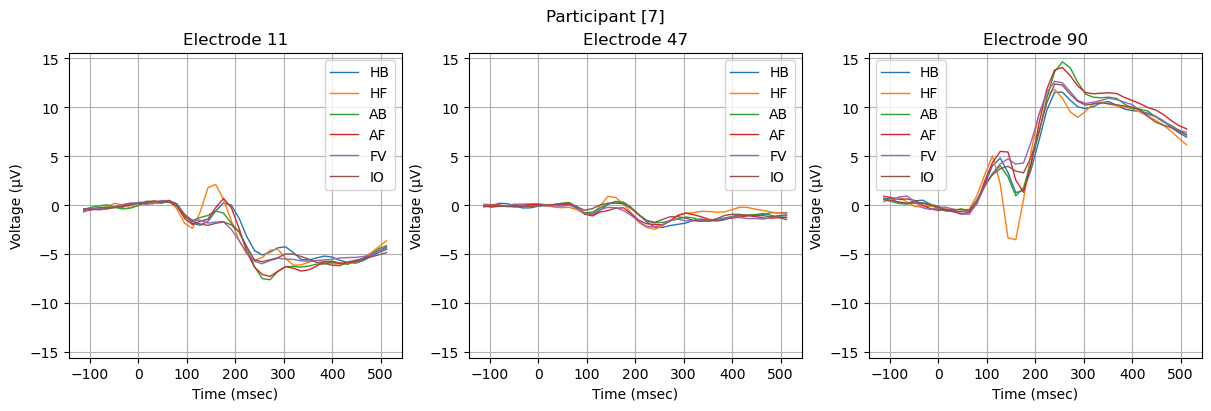

~ * Saved allSubs_1_allCategoryERPs.png * ~


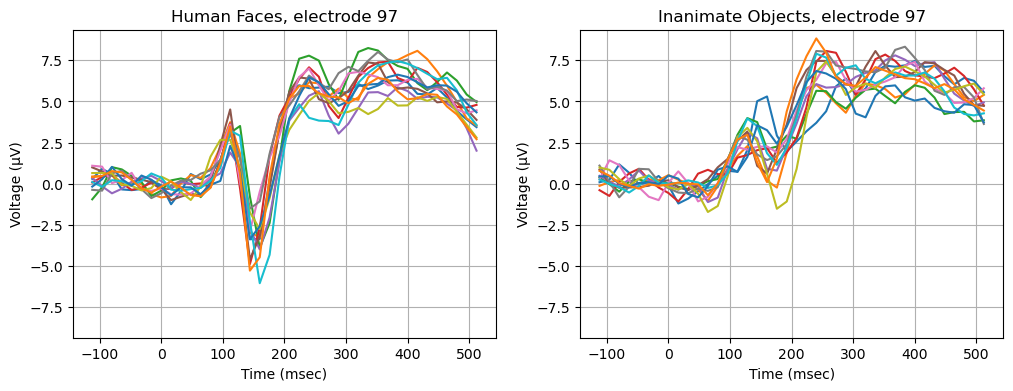


- * - * - * - * Function call complete * - * - * - * -

- * - * - * - * Beginning function call * - * - * - * -

Participant number: 8
Loaded input file S08
Size of data matrix (electrodes x time x trials): (124, 40, 5184)
Number of time samples per second (sampling rate): 62.5 Hz
Trial epoch: -112 to 512 msec relative to stimulus onset.
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 23 12:08:52 2024', '__version__': '1.0', '__globals__': [], 'X': array([[[ 5.13774973e+00, -2.54334454e+00,  1.49350361e+00, ...,
         -2.06978879e+00, -4.70697479e+00,  1.04172293e+00],
        [-6.34913924e-01, -3.21022712e+00, -7.16791468e-01, ...,
          4.89207353e-02,  4.85737518e-01,  3.61083810e-01],
        [-1.05612360e+00, -1.10398090e+00,  2.50160414e+00, ...,
         -4.29844055e+00, -2.05095342e-01,  7.52331938e-01],
        ...,
        [ 2.40471184e+00, -2.64759002e+00,  1.05598294e+00, ...,
         -2.30441163e+00, -4.68373381e+00, -2.58542240e+00],


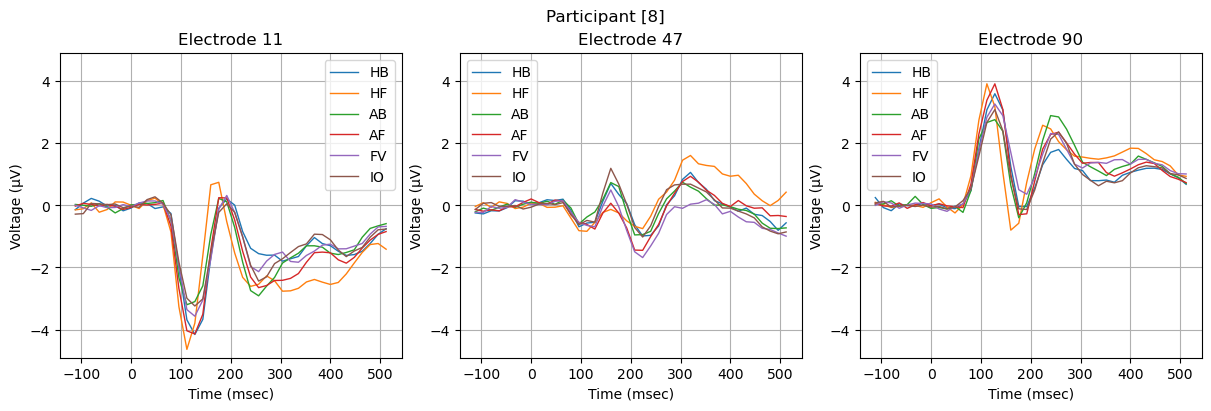

~ * Saved allSubs_1_allCategoryERPs.png * ~


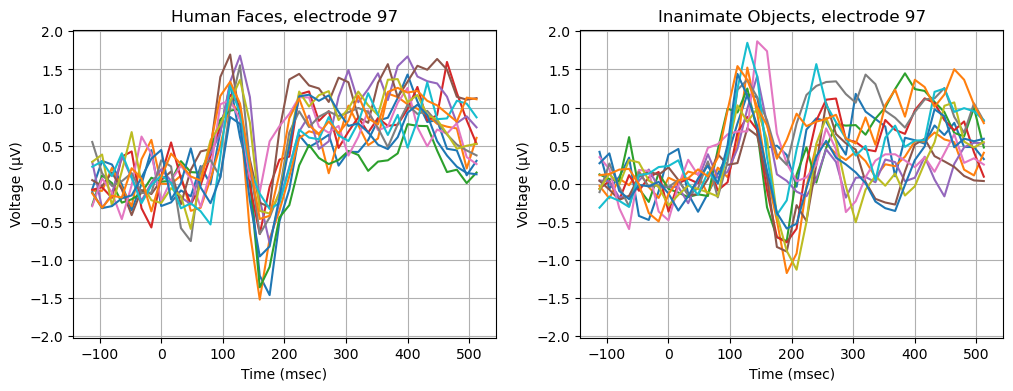


- * - * - * - * Function call complete * - * - * - * -

- * - * - * - * Beginning function call * - * - * - * -

Participant number: 9
Loaded input file S09
Size of data matrix (electrodes x time x trials): (124, 40, 5184)
Number of time samples per second (sampling rate): 62.5 Hz
Trial epoch: -112 to 512 msec relative to stimulus onset.
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 23 12:09:26 2024', '__version__': '1.0', '__globals__': [], 'X': array([[[-1.76971727e+00, -2.09679192e+00,  1.88084312e+00, ...,
         -5.37416032e-01,  6.01067971e-01, -8.69515997e-02],
        [-3.72956249e-01, -1.99560622e+00, -2.39587518e-01, ...,
          3.85848584e+00, -9.92594850e-01, -2.55366409e+00],
        [-8.70110307e-01,  1.35957586e-01, -2.09886598e+00, ...,
          5.47608294e-01, -6.23043451e-01, -1.82381562e+00],
        ...,
        [ 7.57813220e+00, -1.04949861e+01,  1.71421427e+00, ...,
         -3.58785248e+00, -3.07975356e+00,  3.03128117e+00],


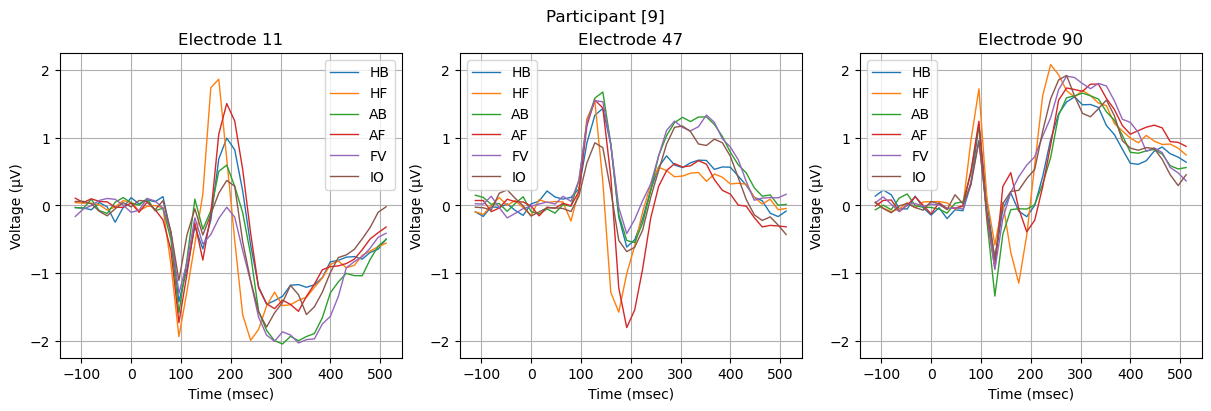

~ * Saved allSubs_1_allCategoryERPs.png * ~


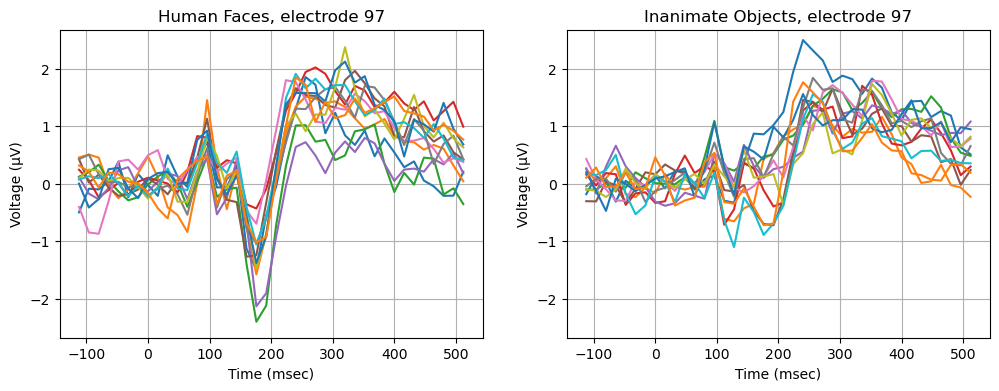


- * - * - * - * Function call complete * - * - * - * -

- * - * - * - * Beginning function call * - * - * - * -

Participant number: 10
Loaded input file S10
Size of data matrix (electrodes x time x trials): (124, 40, 5184)
Number of time samples per second (sampling rate): 62.5 Hz
Trial epoch: -112 to 512 msec relative to stimulus onset.
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 23 12:09:47 2024', '__version__': '1.0', '__globals__': [], 'X': array([[[ -2.90190999,  -3.21572445,   0.29652485, ...,   1.69886043,
          -0.3088719 ,   1.73206212],
        [ -2.21042943,  -2.70716857,   1.86232014, ...,   2.2599482 ,
           0.12903453,   2.77715267],
        [ -1.37614092,  -1.58419938,   1.02345223, ...,   2.64884238,
          -0.38065662,  -0.2158892 ],
        ...,
        [ -5.13978277,   0.64945755,  -5.87840126, ...,  -1.48448412,
           2.27981746,  -6.49190997],
        [ -1.63789603,   1.02837113,  -5.95524203, ...,  -2.82014892,
 

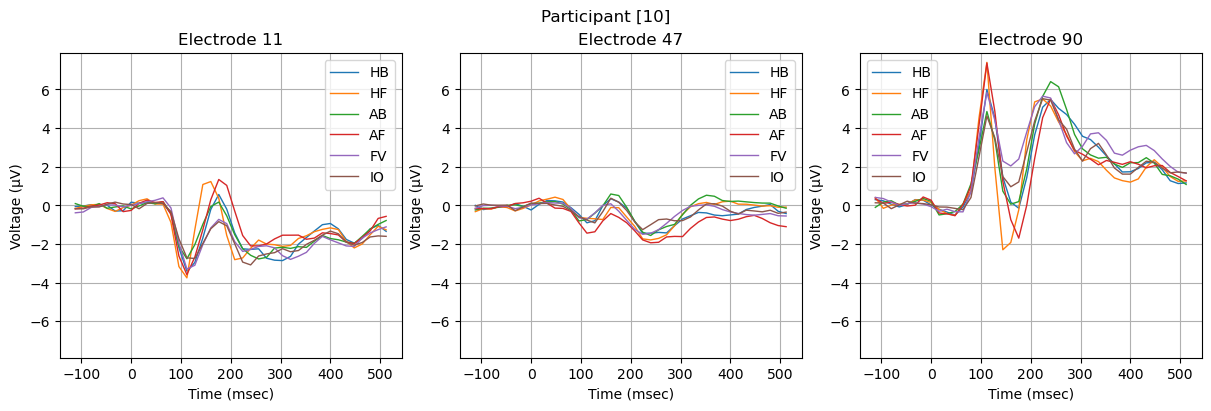

~ * Saved allSubs_1_allCategoryERPs.png * ~


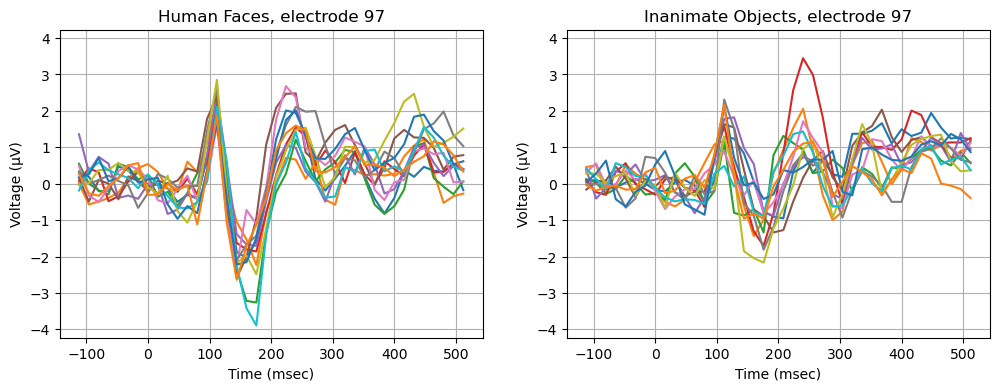


- * - * - * - * Function call complete * - * - * - * -


In [45]:
for i in range(len(data_files)+1):
    CSCEA490_HW_ERP(i)